In [1]:
import pennylane as qml
import torch
from torch import nn
from torch.utils.data import DataLoader
from pennylane import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm
import pennylane as pl
from sklearn.datasets import fetch_california_housing
import torch
from sklearn.metrics import r2_score

#device = 'cpu' # Cuda support for PennyLane is possible though

In [2]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm
import models.quantum_models as qm
from sklearn.model_selection import train_test_split # forgotten by the author

# Evaluation of the model
In the following we will through one run evaluate the results of the model given the different values of rescaling:
- Rescaling [o, pi*2]
    -  mode = half
    -  mode = positive
    -  mode = all
The evaluation metrics are MARE, R sqaured.

This notebook is different from NN_California_2pi as we have changed the evaluation function to compute the metrics mentionned here above.

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

# Assuming fetch_california_housing is already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Split the dataset into training + validation and testing (hold-out set)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2)  # 25% of X_train_val will be X_val

# Now we scale the data, ensuring no data leakage happens

# Calculate scaling parameters (min and max in this case) only from the training set
min_value, max_value = X_train.min(dim=0)[0], X_train.max(dim=0)[0]

# Scale the training data
X_train_scaled = utils.data_scaler(X_train, min_value=min_value, max_value=max_value, interval=(0, torch.pi*2))

# Apply the same scaling to the validation and test data
X_val_scaled = utils.data_scaler(X_val, min_value=min_value, max_value=max_value, interval=(0, torch.pi*2))
X_test_scaled = utils.data_scaler(X_test, min_value=min_value, max_value=max_value, interval=(0, torch.pi*2))


# Create TensorDatasets and DataLoaders with the scaled data
train_dataset = TensorDataset(X_train_scaled, y_train)
val_dataset = TensorDataset(X_val_scaled, y_val)
test_dataset = TensorDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=500)
test_dataloader = DataLoader(test_dataset, batch_size=500)

In [4]:
# Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        # Define the closure function
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output.squeeze(), y)  # Compute loss
            loss.backward()  # Perform backpropagation
            return loss

        loss = closure()  # Compute the loss and perform backpropagation
        optimizer.step(closure)  # Update model parameters using the optimizer

        total_loss += loss.item()  # Accumulate the loss

    average_loss_per_batch = total_loss / num_batches  # Calculate the average loss
    return average_loss_per_batch


# Define evaluation function for both validation and test sets
def evaluate(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_absolute_relative_error = 0
    predictions, targets = [], []
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            output = model(X).squeeze()  # Squeeze the output here as well
            loss = loss_fn(output, y)
            total_loss += loss.item()
            total_absolute_relative_error += torch.abs((y - output) / torch.clamp(y, min=1e-6)).sum().item()
            predictions.extend(output.tolist())
            targets.extend(y.tolist())

    # Calculate average loss and error metrics per batch
    average_loss = total_loss / num_batches
    avg_mare = total_absolute_relative_error / len(dataloader.dataset)  # MARE over the entire dataset
    r2 = r2_score(targets, predictions)  # R² score

    return average_loss, avg_mare, r2



#### 3-a W is generated with Mode = "half"
running time= 220 min 13 s

Epoch 1
-------------------------------
Train Loss: 1.2641
Validation Loss: 1.1598, MARE: 0.5101, R-squared: 0.1182
Epoch 2
-------------------------------
Train Loss: 1.1340
Validation Loss: 0.9440, MARE: 0.4672, R-squared: 0.2716
Epoch 3
-------------------------------
Train Loss: 0.9680
Validation Loss: 0.8293, MARE: 0.4346, R-squared: 0.3598
Epoch 4
-------------------------------
Train Loss: 0.9591
Validation Loss: 1.0536, MARE: 0.4802, R-squared: 0.1858
Epoch 5
-------------------------------
Train Loss: 1.1907
Validation Loss: 3.6385, MARE: 0.8914, R-squared: -1.6917
Epoch 6
-------------------------------
Train Loss: 1.1152
Validation Loss: 1.5477, MARE: 0.5948, R-squared: -0.1763
Epoch 7
-------------------------------
Train Loss: 1.0450
Validation Loss: 1.0408, MARE: 0.4931, R-squared: 0.2234
Epoch 8
-------------------------------
Train Loss: 0.8424
Validation Loss: 0.8216, MARE: 0.4075, R-squared: 0.3628
Epoch 9
-------------------------------
Train Loss: 1.0659
Validation 

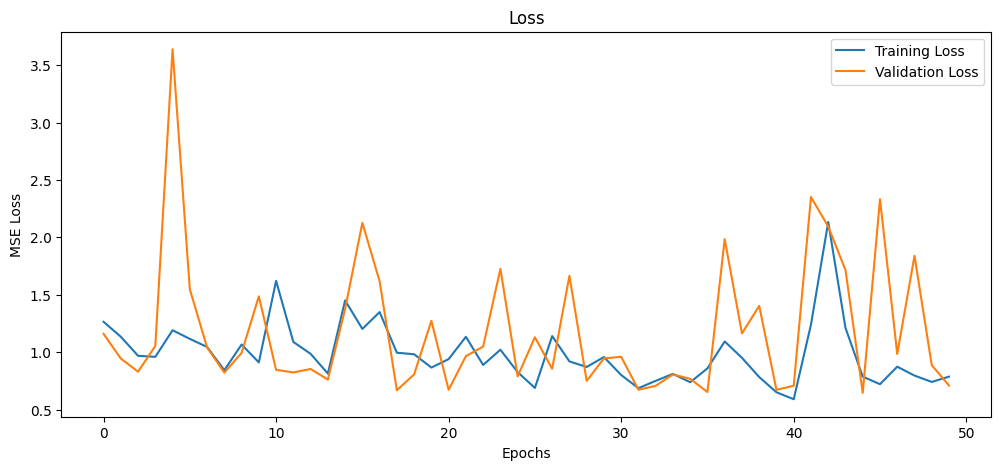

Test Loss: 0.7151, Test MARE: 0.3726, Test R-squared: 0.4727


In [5]:
# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")


#### 3-b W is generated with Mode = "positive"
running time = 16 min 50 s

Epoch 1
-------------------------------
Train Loss: 0.8141
Validation Loss: 0.6467, MARE: 0.3599, R-squared: 0.5010
Epoch 2
-------------------------------
Train Loss: 0.5419
Validation Loss: 0.5788, MARE: 0.3209, R-squared: 0.5591
Epoch 3
-------------------------------
Train Loss: 0.5588
Validation Loss: 0.7235, MARE: 0.3712, R-squared: 0.4539
Epoch 4
-------------------------------
Train Loss: 0.5399
Validation Loss: 0.6018, MARE: 0.3479, R-squared: 0.5459
Epoch 5
-------------------------------
Train Loss: 0.5311
Validation Loss: 0.6074, MARE: 0.3315, R-squared: 0.5469
Epoch 6
-------------------------------
Train Loss: 0.5099
Validation Loss: 0.6100, MARE: 0.3404, R-squared: 0.5413
Epoch 7
-------------------------------
Train Loss: 0.5149
Validation Loss: 0.6712, MARE: 0.3488, R-squared: 0.4911
Epoch 8
-------------------------------
Train Loss: 0.4960
Validation Loss: 0.7550, MARE: 0.3759, R-squared: 0.4363
Epoch 9
-------------------------------
Train Loss: 0.5027
Validation Lo

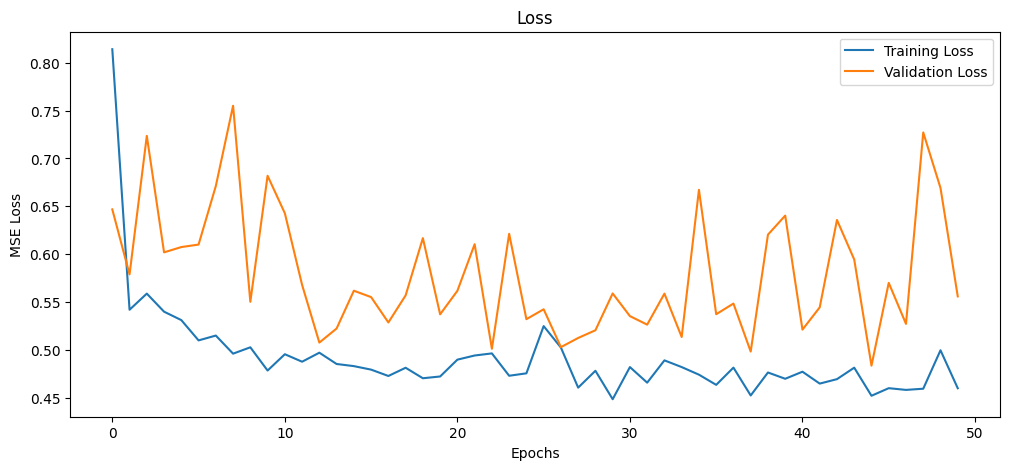

Test Loss: 0.5687, Test MARE: 0.3320, Test R-squared: 0.5756


In [6]:
# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="positive").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")


#### 3-c W is generated with Mode = "all"
running time 384 min 23 s

Epoch 1
-------------------------------
Train Loss: 1.9142
Validation Loss: 1.6107, MARE: 0.5664, R-squared: -0.2177
Epoch 2
-------------------------------
Train Loss: 1.0213
Validation Loss: 0.8985, MARE: 0.4344, R-squared: 0.3164
Epoch 3
-------------------------------
Train Loss: 1.0607
Validation Loss: 1.3699, MARE: 0.5865, R-squared: -0.0454
Epoch 4
-------------------------------
Train Loss: 1.1492
Validation Loss: 2.3696, MARE: 0.7421, R-squared: -0.8464
Epoch 5
-------------------------------
Train Loss: 1.9037
Validation Loss: 5.9188, MARE: 1.0754, R-squared: -3.5764
Epoch 6
-------------------------------
Train Loss: 1.9038
Validation Loss: 2.4659, MARE: 0.7193, R-squared: -0.9131
Epoch 7
-------------------------------
Train Loss: 2.1131
Validation Loss: 2.7446, MARE: 0.8240, R-squared: -1.0861
Epoch 8
-------------------------------
Train Loss: 2.0345
Validation Loss: 1.5862, MARE: 0.5809, R-squared: -0.2231
Epoch 9
-------------------------------
Train Loss: 2.6191
Valida

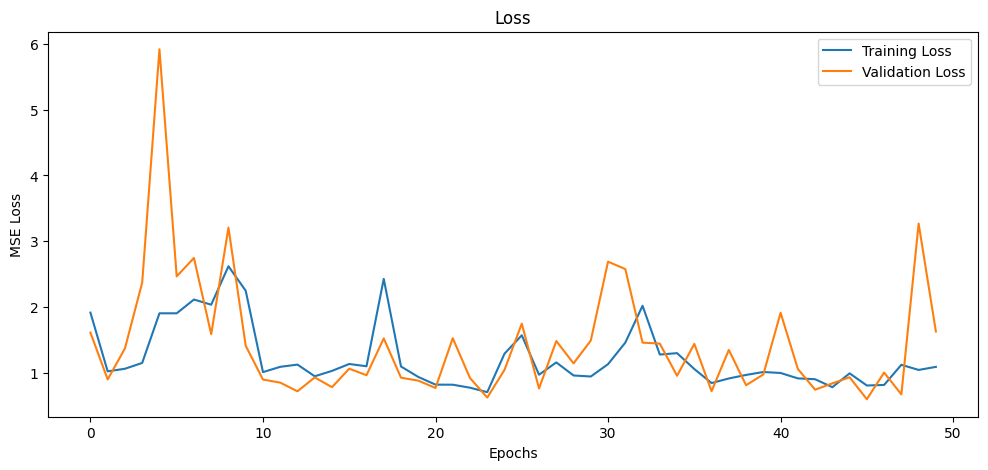

Test Loss: 1.7459, Test MARE: 0.6286, Test R-squared: -0.2595


In [7]:
# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="all").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")
